In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

""" Semilla """

seed = 99

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/eduardofc/data/main/kddcup99.csv')

print(f'Número de filas: {df.shape[0]}, Número de columnas:{df.shape[1]}')
df.head()

Número de filas: 561, Número de columnas:10


,duration,protocol_type,service,flag,count,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate,labels
0,0,b'tcp',b'http',b'SF',0,0,0.0,0,0.0,b'normal.'
1,0,b'tcp',b'http',b'SF',0,0,0.0,1,0.0,b'normal.'
2,0,b'tcp',b'http',b'SF',0,1,0.0,1,0.0,b'normal.'
3,0,b'tcp',b'http',b'SF',0,0,1.0,1,0.0,b'normal.'
4,0,b'tcp',b'http',b'SF',0,0,0.0,1,1.0,b'normal.'


In [3]:
df.dtypes

# df.describe() # numéricas

duration                      int64
protocol_type                object
service                      object
flag                         object
count                         int64
srv_count                     int64
serror_rate                 float64
dst_host_srv_count            int64
dst_host_srv_serror_rate    float64
labels                       object
dtype: object

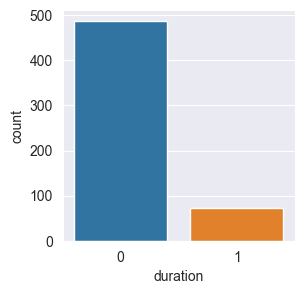

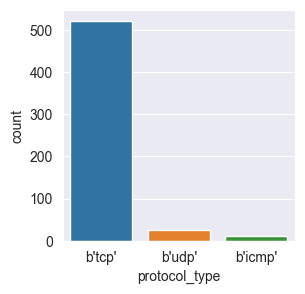

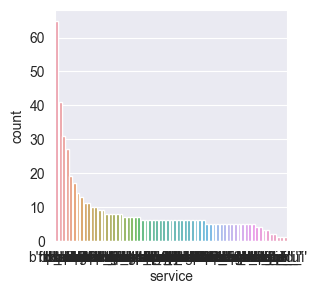

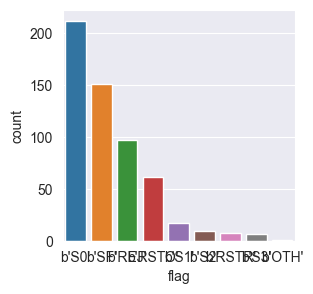

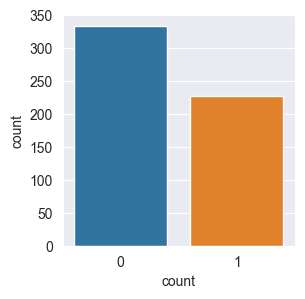

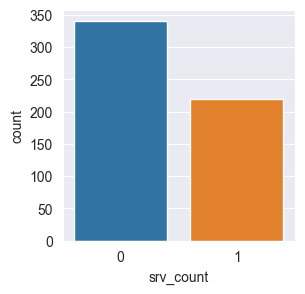

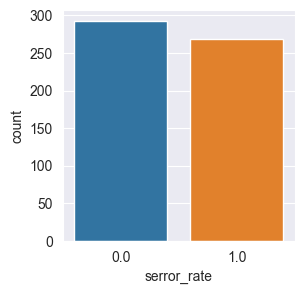

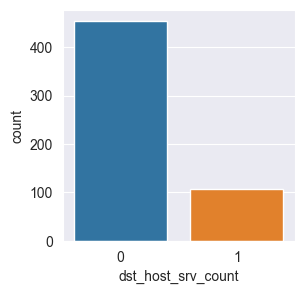

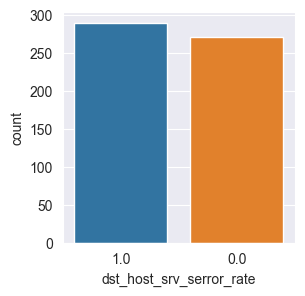

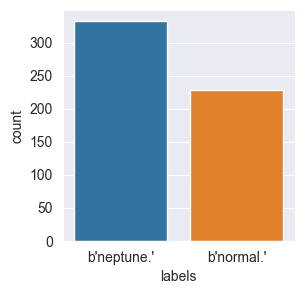

In [4]:
for col in df.columns:
    plt.figure(figsize=(3,3))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index) # order elem estético
    plt.show()

## lo mismo pero sin gráficos:
# for col in df.columns:
#     print(f"Columna: {col}")
#     print(df[col].value_counts())
#     print()

In [5]:
# flag (cuidado con ejecutar este código más de una vez)
aux = df.flag.value_counts()
print(f'Las 2 categorías más representadas de "flag" son\n {aux.index[0]} ({aux[0]} veces) y\n {aux.index[1]} ({aux[1]} veces)')
print(f'Por tanto, el resto de categorías {[aux.index[i] for i in range(2, len(aux.index))]} \n deben agruparse en la categoría "resto"')

print(aux.index[0:2]) # coge 2 categorías, no 3, no te líes con python!

df.flag = df.flag.apply(lambda x: x if x in aux.index[0:2] else 'resto')

df.flag.value_counts() # comprobar

Las 2 categorías más representadas de "flag" son
 b'S0' (212 veces) y
 b'SF' (151 veces)
Por tanto, el resto de categorías ["b'REJ'", "b'RSTO'", "b'S1'", "b'S2'", "b'RSTR'", "b'S3'", "b'OTH'"] 
 deben agruparse en la categoría "resto"
Index(['b'S0'', 'b'SF''], dtype='object')


b'S0'    212
resto    198
b'SF'    151
Name: flag, dtype: int64

In [6]:
# service
aux2 = df.service.value_counts()
df.service = df.service.apply(lambda x: x if x in aux2.index[0:2] else 'resto')
df.service.value_counts() # comprobar

resto          455
b'http'         65
b'ftp_data'     41
Name: service, dtype: int64

In [7]:
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier(random_state=seed)))

def boxplots_algorithms(results, names):
    plt.figure(figsize=(8,4))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()
    
def pca_results(results, names, components):
    df2 = pd.DataFrame(zip(results, names, components), columns=['results', 'names', 'components'])
    
    sns.catplot(data=df2, kind="bar", x="names", y="results", hue="components", height=5, aspect=15/5)
    plt.ylim((0.9, 1.))
    plt.show()
    
cat_cols = ['protocol_type', 'service', 'flag']
num_cols = ['duration', 'count', 'srv_count', 'serror_rate', 
            'dst_host_srv_count', 'dst_host_srv_serror_rate']
target = 'labels'

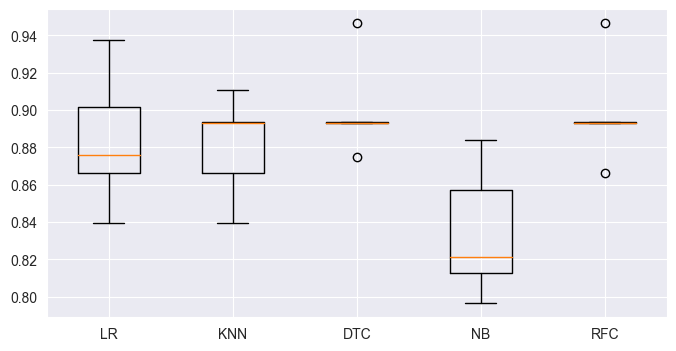

In [8]:
results = []
names = []
 
for name, model in models:
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    cv_results = cross_val_score(
        estimator=model,
        X=df[num_cols], # solo las variabs numéricas
        y=df[target],
        cv=kf, 
        scoring='accuracy' # (con accuracy me pasa la celda de control)
    )
    results.append(cv_results)
    names.append(name)

boxplots_algorithms(results, names)

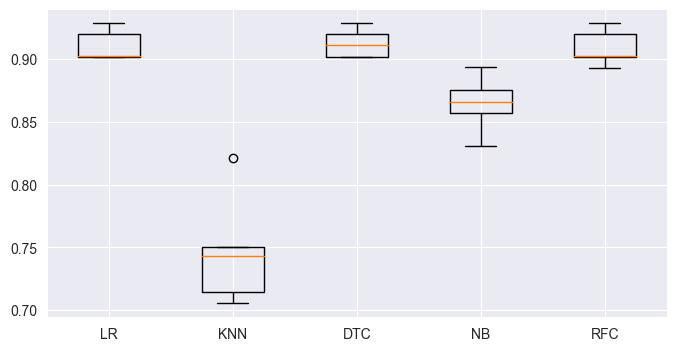

In [9]:
results = []
names = []
 
for name, model in models:
    ct = ColumnTransformer([
        ('onehot', OneHotEncoder(), cat_cols)
        ], remainder='drop'
    )
    pipe = Pipeline([
        ('col_transf', ct),
        ('algorithm', model)
    ])
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    cv_results = cross_val_score(
        estimator=pipe,
        X=df[cat_cols+num_cols],
        y=df[target],
        cv=kf,
        scoring='accuracy'
    )
    results.append(cv_results)
    names.append(name)
 
boxplots_algorithms(results, names)

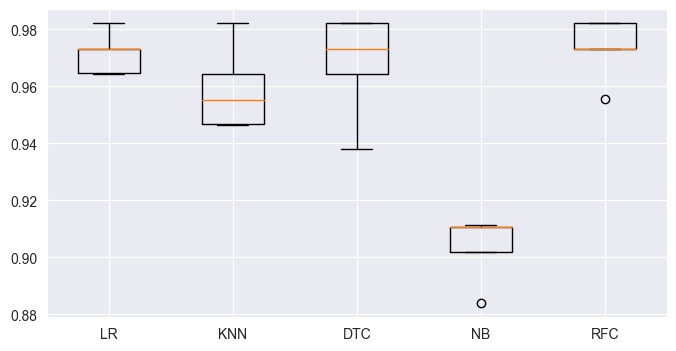

In [10]:
results = []
names = []
 
for name, model in models:
    ct = ColumnTransformer([
        ('onehot', OneHotEncoder(), cat_cols)
        ], remainder='passthrough' # ahora con passthrough
    )
    pipe = Pipeline([
        ('col_transf', ct),
        ('algorithm', model)
    ])
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    cv_results = cross_val_score(
        estimator=pipe,
        X=df[cat_cols+num_cols],
        y=df[target],
        cv=kf,
        scoring='accuracy'
    )
    results.append(cv_results)
    names.append(name)
 
boxplots_algorithms(results, names) # la precisión ha aumentado!

## Modelos 4

Model: LR, PCA components: 2
Confusion matrix:
[[322  11]
 [ 24 204]]

Model: LR, PCA components: 3
Confusion matrix:
[[322  11]
 [ 25 203]]

Model: LR, PCA components: 4
Confusion matrix:
[[315  18]
 [ 17 211]]

Model: LR, PCA components: 5
Confusion matrix:
[[316  17]
 [ 19 209]]

Model: KNN, PCA components: 2
Confusion matrix:
[[328   5]
 [ 13 215]]

Model: KNN, PCA components: 3
Confusion matrix:
[[319  14]
 [  9 219]]

Model: KNN, PCA components: 4
Confusion matrix:
[[323  10]
 [ 10 218]]

Model: KNN, PCA components: 5
Confusion matrix:
[[323  10]
 [ 11 217]]

Model: DTC, PCA components: 2
Confusion matrix:
[[331   2]
 [ 15 213]]

Model: DTC, PCA components: 3
Confusion matrix:
[[331   2]
 [ 15 213]]

Model: DTC, PCA components: 4
Confusion matrix:
[[330   3]
 [ 16 212]]

Model: DTC, PCA components: 5
Confusion matrix:
[[330   3]
 [ 16 212]]

Model: NB, PCA components: 2
Confusion matrix:
[[333   0]
 [ 44 184]]

Model: NB, PCA components: 3
Confusion matrix:
[[327   6]
 [ 38 190]]

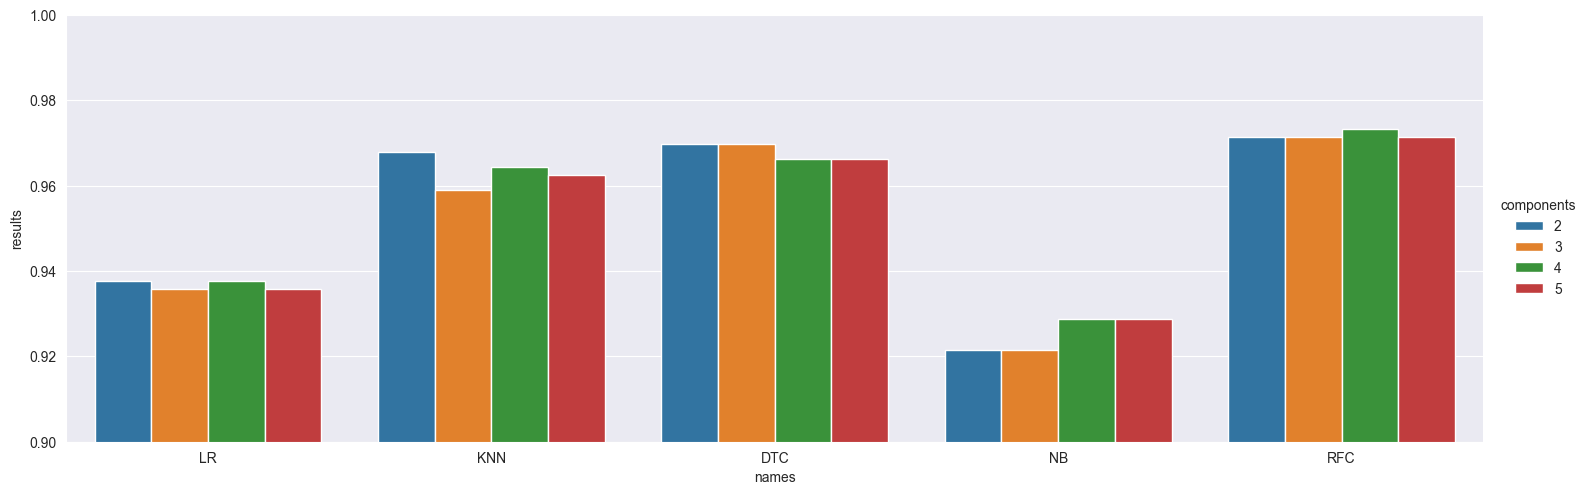

In [19]:
results = []
names = []
components = []

## comentario: he descubierto que puedo hacer:
# num_pipe & cat_pipe --> col_transf( ...num_pipe, cat_pipe...) --> otro pipeline(model, etc)
# lo uso aquí (aunque no es necesario, podríamos definir todo ya en el ct)

## LO DEJO COMENTADO. El profe me ha pedido por email usar solo ct + pipe en el ejerc
#         num_transf = Pipeline([
#             ('pca', PCA(n_components=n, random_state=seed))
#         ])
#         cat_transf = Pipeline([
#             ('onehot', OneHotEncoder(drop='if_binary'))
#         ])
#         ct = ColumnTransformer([
#             ('cat', cat_transf, cat_cols),
#             ('num', num_transf, num_cols)
#             ], remainder='passthrought' # da igual drop o pass, estamos usando todas las variabs en los transformers
#         )
#         pipe = Pipeline([
#             ('col_transf', ct), # preprocessor
#             ('algorithm', model)
#         ])

for name, model in models:
    for n in range(2,6): # valores para PCA_comps
        ct = ColumnTransformer([
            ('onehot', OneHotEncoder(drop='if_binary'), cat_cols),
            ], remainder='passthrough' # necesario pass, si pones drop, las demás variabs no siguen por el pipe
        )
        pipe = Pipeline([
            ('col_transf', ct), # preprocessor
            ('pca', PCA(n_components=n, random_state=seed)),
            ('algorithm', model)
        ])
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        
        y_pred = cross_val_predict( # calculamos la predicción para poder mostrar la confusion_matrix
            estimator=pipe,
            X=df[cat_cols+num_cols],
            y=df[target],
            cv=kf
        )
        cm = confusion_matrix(y_true=df[target], y_pred=y_pred)
        print(f'Model: {name}, PCA components: {n}')
        print('Confusion matrix:')
        print(f'{cm}\n')
        
        cv_results = cross_val_score(
            estimator=pipe,
            X=df[cat_cols+num_cols],
            y=df[target],
            cv=kf # ,
            # scoring='accuracy' # if None, uses estimator's default scorer (if available)
        )
        results.append(np.mean(cv_results)) # valor medio en cada iteracción (*)
        names.append(name)
        components.append(n)

# (*) para cada modelo y cada n calculamos 5 KFolds_CV, luego tenemos que guardar la media para tener su 'score'

pca_results(results, names, components)

In [24]:
[np.round(results[x], 3) for x in [1,10,17]]

[0.936, 0.966, 0.972]

## Modelos 5


In [15]:
model = RandomForestClassifier(random_state=seed)
# model = models[4][1]

X = df[cat_cols+num_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True) # X,y en fmto array

ct = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='if_binary'), cat_cols),
    ], remainder='passthrough'
)
pipe = Pipeline([
    ('col_transf', ct),
    ('algorithm', model)
])

pipe.fit(X_train, y_train) # entrenamos
y_train_pred = pipe.predict(X_train) # predecimos y_train
y_test_pred = pipe.predict(X_test) # predecimos y_test

# confusion matrix
cm_train = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
cm_test = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print('Confusion matrix of train_data:')
print(f'{cm_train}\n')
print('Confusion matrix of test_data:')
print(f'{cm_test}\n')

# accuracy
acc_train = pipe.score(X_train, y_train)
acc_test = pipe.score(X_test, y_test)

Confusion matrix of train_data:
[[265   0]
 [  9 174]]

Confusion matrix of test_data:
[[68  0]
 [ 5 40]]



In [35]:
# algoritmo
model = RandomForestClassifier(random_state=seed)

# train-test split
X = df[cat_cols+num_cols]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

ct = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='if_binary'), cat_cols),
    ], remainder='passthrough'
)
pipe = Pipeline([
    ('col_transf', ct),
    ('algorithm', model)
])

# método de entrenamiento (cross_val)
cv_technique = KFold(n_splits=5, shuffle=True, random_state=seed)

# malla de paráms
parametros = {
    "algorithm__n_estimators": [10,20,30],
    "algorithm__max_features": ['auto','sqrt','log2'],
    "algorithm__max_depth": [10,20,50,70,100],
    "algorithm__criterion": ['gini','entropy']
}

# combinamos todo
gsearch = GridSearchCV(estimator=pipe, cv=cv_technique, param_grid=parametros)

# buscamos el mejor modelo
grid_model = gsearch.fit(X_train, y_train)
best_model = grid_model.best_estimator_ # max_depth=10, max_features='auto', n_estimators=10

# predicciones con el mejor modelo
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# confusion matrix
cm_train = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
cm_test = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

# accuracy
acc_train = best_model.score(X_train, y_train)
acc_test = best_model.score(X_test, y_test)

print(cm_train)
print(acc_train)

print(cm_test)
print(acc_test)

print(f'Best score: {grid_model.best_score_:.4f}')
grid_model.best_estimator_

[[265   0]
 [  9 174]]
0.9799107142857143
[[67  1]
 [ 4 41]]
0.9557522123893806
Best score: 0.9733


Pipeline(steps=[('col_transf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['protocol_type', 'service',
                                                   'flag'])])),
                ('algorithm',
                 RandomForestClassifier(max_depth=10, max_features='auto',
                                        n_estimators=10, random_state=99))])